In [0]:
%pip install openpyxl

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

import mlflow
import mlflow.spark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score,confusion_matrix,precision_recall_curve)
from sklearn.model_selection import GroupShuffleSplit

In [0]:
# Copying files from DBFS to local temp.
dbutils.fs.cp("dbfs:/FileStore/annual_features.xlsx", "file:/tmp/annual_features.xlsx")
dbutils.fs.cp("dbfs:/FileStore/annual_day_of_week_counts_pivot.xlsx", "file:/tmp/annual_day_of_week_counts_pivot.xlsx")
dbutils.fs.cp("dbfs:/FileStore/mth_rolling_features.xlsx", "file:/tmp/mth_rolling_features.xlsx")
dbutils.fs.cp("dbfs:/FileStore/mth_day_counts.xlsx", "file:/tmp/mth_day_counts.xlsx") 
dbutils.fs.cp("dbfs:/FileStore/days_since_last_txn.xlsx", "file:/tmp/days_since_last_txn.xlsx")
dbutils.fs.cp("dbfs:/FileStore/tables/Retail_Data_Response.csv", "file:/tmp/Retail_Data_Response.csv")

Out[2]: True

### Q 1.1.

In [0]:
# Importing the tables of annual features.
a1 = pd.read_excel("/tmp/annual_features.xlsx")
a2 = pd.read_excel("/tmp/annual_day_of_week_counts_pivot.xlsx")

# Converting to Spark DataFrames.
a1 = spark.createDataFrame(a1)
a2 = spark.createDataFrame(a2)

In [0]:
# Importing the tables of monthly features.
m1 = pd.read_excel("/tmp/mth_rolling_features.xlsx")
m2 = pd.read_excel("/tmp/mth_day_counts.xlsx")
m3 = pd.read_excel("/tmp/days_since_last_txn.xlsx")

# Converting to Spark DataFrames.
m1 = spark.createDataFrame(m1)
m2 = spark.createDataFrame(m2)
m3 = spark.createDataFrame(m3)

In [0]:
# Importing the response table.
resp = pd.read_csv("/tmp/Retail_Data_Response.csv")
# Converting to Spark DataFrame.
resp = spark.createDataFrame(resp)

In [0]:
# Join a1 and a2 on "customer_id"
annual_feat = a1.join(a2, on="customer_id", how="inner")
# Join the result with resp on "customer_id"
annual_data = annual_feat.join(resp, on="customer_id", how="inner")
# Show the first few rows
annual_data = annual_data.orderBy("customer_id")
annual_data.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+-----------------+---------------+-----------------+----------------+------------------+---------------+-----------

In [0]:
# Join m1 and m2 on ["CLNT_NO", "ME_DT"]
monthly_feat = m1.join(m2, on=["CLNT_NO", "ME_DT"], how="inner")
# Join the result with m3 on ["CLNT_NO", "ME_DT"]
monthly_feat = monthly_feat.join(m3, on=["CLNT_NO", "ME_DT"], how="inner")
# Rename 'customer_id' to 'CLNT_NO' in resp DataFrame
resp = resp.withColumnRenamed("customer_id", "CLNT_NO")
# Join monthly features with the response table on 'CLNT_NO'
monthly_data = monthly_feat.join(resp, on="CLNT_NO", how="inner")
# Drop rows with any null (NaN) values
monthly_data = monthly_data.na.drop()
# Show first few rows
monthly_data = monthly_data.orderBy("CLNT_NO", "ME_DT")
monthly_data.show(5)

+-------+-------------------+---------------+-----------+----------+-----------------+----------+--------------+------------------+--------------+----------+-----------------+----------+--------------+------------------+--------------+-----------+-----------------+-----------+---------------+------------------+---------------+----------+----------+------------+----------+------------+-----------+-------------+-------------------+--------+
|CLNT_NO|              ME_DT|mth_txn_amt_sum|mth_txn_cnt|amt_sum_3M|      amt_mean_3M|amt_max_3M|txn_cnt_sum_3M|   txn_cnt_mean_3M|txn_cnt_max_3M|amt_sum_6M|      amt_mean_6M|amt_max_6M|txn_cnt_sum_6M|   txn_cnt_mean_6M|txn_cnt_max_6M|amt_sum_12M|     amt_mean_12M|amt_max_12M|txn_cnt_sum_12M|  txn_cnt_mean_12M|txn_cnt_max_12M|cnt_Friday|cnt_Monday|cnt_Saturday|cnt_Sunday|cnt_Thursday|cnt_Tuesday|cnt_Wednesday|days_since_last_txn|response|
+-------+-------------------+---------------+-----------+----------+-----------------+----------+--------------+--

### Q 1.2.

In [0]:
# 1. Separating inputs X and output y
# For annual data
X_annual = annual_data.drop("customer_id", "response")
y_annual = annual_data.select("response")  # Keep original name
# For monthly data
X_monthly = monthly_data.drop("CLNT_NO", "ME_DT", "response")
y_monthly = monthly_data.select("response")  # Keep original name

In [0]:
# 2. Splitting the data into train and test sets.
# Annual data - balanced random split.
annual_positive = annual_data.filter(col("response") == 1)
annual_negative = annual_data.filter(col("response") == 0)
# Splitting the positive cases (simple random split, no client-level needed)
train_annual_positive, test_annual_positive = annual_positive.randomSplit([1/3, 2/3], seed=1147)
# Splitting the negative cases.
train_annual_negative, test_annual_negative = annual_negative.randomSplit([1/3, 2/3], seed=1147)
# Balancing the training set by matching positive count.
positive_count = train_annual_positive.count()
train_annual_negative = train_annual_negative.limit(positive_count)
# Creating the final annual datasets.
train_annual = train_annual_positive.union(train_annual_negative)
test_annual = test_annual_positive.union(test_annual_negative)

In [0]:
# Monthly data - client-level split (to avoid data leakage)
monthly_positive = monthly_data.filter(col("response") == 1)
monthly_negative = monthly_data.filter(col("response") == 0)
# Converting to pandas for GroupShuffleSplit.
monthly_positive_pd = monthly_positive.toPandas()
monthly_negative_pd = monthly_negative.toPandas()
# Splitting positive cases by client.
splitter = GroupShuffleSplit(test_size=2/3, n_splits=2, random_state=1147)
groups = monthly_positive_pd['CLNT_NO']
split = splitter.split(monthly_positive_pd, groups=groups)
train_inds, test_inds = next(split)
monthly_positive_train_pd = monthly_positive_pd.iloc[train_inds]
monthly_positive_test_pd = monthly_positive_pd.iloc[test_inds]
# Splitting negative cases by client.
groups = monthly_negative_pd['CLNT_NO']
split = splitter.split(monthly_negative_pd, groups=groups)
train_inds, test_inds = next(split)
monthly_negative_train_pd = monthly_negative_pd.iloc[train_inds]
monthly_negative_test_pd = monthly_negative_pd.iloc[test_inds]
# Converting back to Spark DataFrames.
monthly_positive_train = spark.createDataFrame(monthly_positive_train_pd)
monthly_positive_test = spark.createDataFrame(monthly_positive_test_pd)
monthly_negative_train = spark.createDataFrame(monthly_negative_train_pd)
monthly_negative_test = spark.createDataFrame(monthly_negative_test_pd)
# Balancing the training set.
positive_count = monthly_positive_train.count()
monthly_negative_train = monthly_negative_train.limit(positive_count)
# Creating the final monthly datasets.
train_monthly = monthly_positive_train.union(monthly_negative_train)
test_monthly = monthly_positive_test.union(monthly_negative_test)

In [0]:
# 3. Pre-processing - Feature scaling and Assembling.
# Defining feature columns separately for annual and monthly data.
# For annual data (excluding customer_id and response)
annual_feature_cols = [c for c in X_annual.columns if c not in ['customer_id', 'response']]
annual_assembler = VectorAssembler(inputCols=annual_feature_cols, outputCol="features")
annual_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", 
                             withStd=True, withMean=True)
# For monthly data (excluding CLNT_NO, ME_DT, and response)
monthly_feature_cols = [c for c in X_monthly.columns if c not in ['CLNT_NO', 'ME_DT', 'response']]
monthly_assembler = VectorAssembler(inputCols=monthly_feature_cols, outputCol="features")
monthly_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", 
                              withStd=True, withMean=True)

In [0]:
# Making predictions.
def get_predictions(model, train_df, test_df):
    train_pred = model.transform(train_df)
    test_pred = model.transform(test_df)
    return train_pred, test_pred

In [0]:
# 5. Plot coefficient values.
def plot_coefficients(model, feature_names, title):
    coefficients = model.stages[-1].coefficients.toArray()
    plt.figure(figsize=(12, 10))  
    plt.barh(range(len(coefficients)), coefficients, tick_label=feature_names)
    plt.title(title, pad=20)  
    plt.xlabel("Coefficient Value", labelpad=10)
    plt.ylabel("Feature", labelpad=10)
    plt.tight_layout()
    plt.show()
# 5. Plot feature importance.
def plot_feature_importance(model, feature_names, title):
    importances = model.stages[-1].featureImportances.toArray()
    indices = np.argsort(importances)
    plt.figure(figsize=(12, 10)) 
    plt.barh(range(len(indices)), importances[indices], tick_label=np.array(feature_names)[indices],height=0.8) 
    plt.title(title, pad=20)
    plt.xlabel("Feature Importance", labelpad=10)
    plt.ylabel("Feature", labelpad=10)
    
    # Adjusting margins and layout for more space for feature names.
    plt.subplots_adjust(left=0.3)  
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [0]:
# 6. Plotting probability distribution for test set.
def plot_probability_distribution(predictions, title):
    probs = predictions.select(vector_to_array('probability')[1]).rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(10, 6))
    plt.hist(probs, bins=20)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()

In [0]:
# 7. Plotting confusion matrix and ROC curves of train/test set and calculating precision and recall.
def evaluate_model(predictions_train, predictions_test, title_prefix):
    # Collecting predictions and true values for train and test.
    y_pred_train = predictions_train.select('prediction').rdd.flatMap(lambda x: x).collect()
    y_true_train = predictions_train.select('response').rdd.flatMap(lambda x: x).collect()
    y_score_train = predictions_train.select(vector_to_array('probability')[1]).rdd.flatMap(lambda x: x).collect()
    y_pred_test = predictions_test.select('prediction').rdd.flatMap(lambda x: x).collect()
    y_true_test = predictions_test.select('response').rdd.flatMap(lambda x: x).collect()
    y_score_test = predictions_test.select(vector_to_array('probability')[1]).rdd.flatMap(lambda x: x).collect()
    # Evaluating the Confusion matrices.
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_test = confusion_matrix(y_true_test, y_pred_test)

    plt.figure(figsize=(18, 5))
    # Confusion matrix for Train set.
    plt.subplot(1, 3, 1)
    plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative','Positive']
    plt.title(f'{title_prefix} - Train Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm_train.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{s[i][j]} = {cm_train[i][j]}", 
                    fontsize=12, horizontalalignment="center",
                    color="white" if cm_train[i, j] > thresh else "black")
    
    # Confusion matrix for Test set.
    plt.subplot(1, 3, 2)
    plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{title_prefix} - Test Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    thresh = cm_test.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{s[i][j]} = {cm_test[i][j]}", 
                    fontsize=12, horizontalalignment="center",
                    color="white" if cm_test[i, j] > thresh else "black")
    plt.subplot(1, 3, 3)
    
    # Evaluating Train ROC
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
             label=f'Train ROC (AUC = {roc_auc_train:.2f})')
    # Evaluating Test ROC
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_score_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='green', lw=2, 
             label=f'Test ROC (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} - ROC Curves')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    # Calculating metrics for both train and test.
    def calculate_metrics(cm):
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        return precision, recall
    
    prec_train, rec_train = calculate_metrics(cm_train)
    prec_test, rec_test = calculate_metrics(cm_test)
    print(f"{title_prefix} Metrics:")
    print(f"Train - Precision: {prec_train:.4f}, Recall: {rec_train:.4f}, AUC: {roc_auc_train:.4f}")
    print(f"Test  - Precision: {prec_test:.4f}, Recall: {rec_test:.4f}, AUC: {roc_auc_test:.4f}")

#### Logistic Regression Models with L1 Regularization (Lasso).

In [0]:
# 4. Fitting the models with L1 regularization using found Optimal parameters.
log_reg_annual = LogisticRegression(featuresCol='scaledFeatures', 
                                  labelCol='response', 
                                  elasticNetParam=1,
                                  regParam=0.07)
log_reg_monthly = LogisticRegression(featuresCol='scaledFeatures', 
                                   labelCol='response',  
                                   elasticNetParam=1,
                                   regParam=0.02)
# Creating pipelines.
pipeline_annual_lr = Pipeline(stages=[annual_assembler, annual_scaler, log_reg_annual])
pipeline_monthly_lr = Pipeline(stages=[monthly_assembler, monthly_scaler, log_reg_monthly])
# Fitting the models.
model_annual_lr = pipeline_annual_lr.fit(train_annual)
model_monthly_lr = pipeline_monthly_lr.fit(train_monthly)

#### Comment on hyper-parameter tuning:
- The optimal parameters were found using a 3-fold crossvalidation method in an external file due to extremely long search times. Below is a snippet of the search code carried out on annual and monthly data for logistic Regression with L1 Regularization.

In [0]:
"""
# 1. Define evaluator
auc_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")

# 2. ANNUAL MODEL 
annual_lr_cv = CrossValidator(
    estimator=LogisticRegression(featuresCol='scaledFeatures', labelCol='response', elasticNetParam=1),  # L1
    estimatorParamMaps=ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.05, 0.07, 0.1]).build(),  # Test near 0.07
    evaluator=auc_evaluator, numFolds=3, seed=1147, parallelism=3)

# 3. MONTHLY MODEL  
monthly_lr_cv = CrossValidator(
    estimator=LogisticRegression(featuresCol='scaledFeatures', labelCol='response', elasticNetParam=1),  # L1
    estimatorParamMaps=ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.015, 0.02, 0.025]).build(),  # Test near 0.02
    evaluator=auc_evaluator, numFolds=3, seed=1147, parallelism=3)

# 4. Pipelines
annual_lr_pipeline = Pipeline(stages=[annual_assembler, annual_scaler, annual_lr_cv])
monthly_lr_pipeline = Pipeline(stages=[monthly_assembler, monthly_scaler, monthly_lr_cv])

# 5. Model tracking
model_registry = {
    'annual_lr': annual_lr_cv, 'monthly_lr': monthly_lr_cv,
    'annual_pipeline': annual_lr_pipeline, 'monthly_pipeline': monthly_lr_pipeline
}

# 6. Train models
print("Training ANNUAL LR (3-fold CV)...")
model_annual_lr = annual_lr_pipeline.fit(train_annual)
print("Training MONTHLY LR (3-fold CV)...")
model_monthly_lr = monthly_lr_pipeline.fit(train_monthly)

# 7. Best params
print(f"\nBest Params:\nAnnual - regParam: {model_annual_lr.stages[-1].bestModel.getRegParam():.4f}\nMonthly - regParam: {model_monthly_lr.stages[-1].bestModel.getRegParam():.4f}")
"""

Out[17]: '\n# 1. Define evaluator\nauc_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")\n\n# 2. ANNUAL MODEL \nannual_lr_cv = CrossValidator(\n    estimator=LogisticRegression(featuresCol=\'scaledFeatures\', labelCol=\'response\', elasticNetParam=1),  # L1\n    estimatorParamMaps=ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.05, 0.07, 0.1]).build(),  # Test near 0.07\n    evaluator=auc_evaluator, numFolds=3, seed=1147, parallelism=3)\n\n# 3. MONTHLY MODEL  \nmonthly_lr_cv = CrossValidator(\n    estimator=LogisticRegression(featuresCol=\'scaledFeatures\', labelCol=\'response\', elasticNetParam=1),  # L1\n    estimatorParamMaps=ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.015, 0.02, 0.025]).build(),  # Test near 0.02\n    evaluator=auc_evaluator, numFolds=3, seed=1147, parallelism=3)\n\n# 4. Pipelines\nannual_lr_pipeline = Pipeline(stages=[annual_assembler, annual_scaler, annual_lr_cv])\nmonthly_lr_pipeline = Pipeline(st

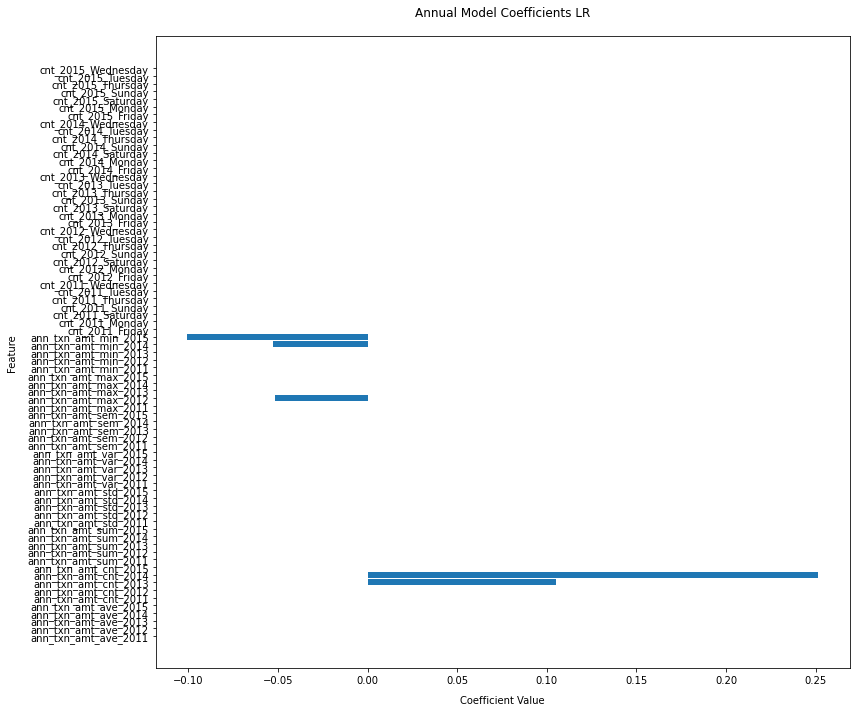

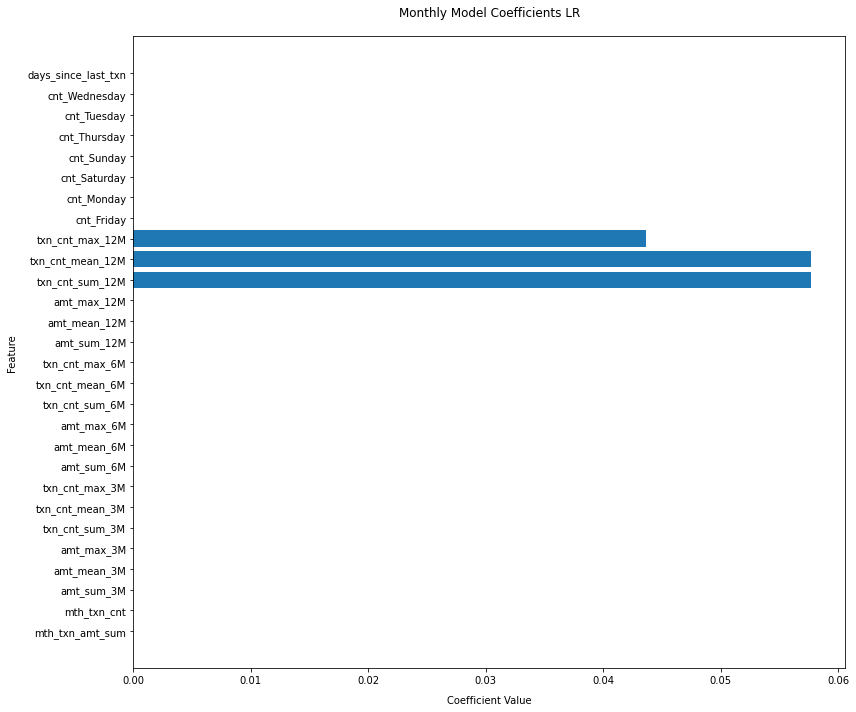

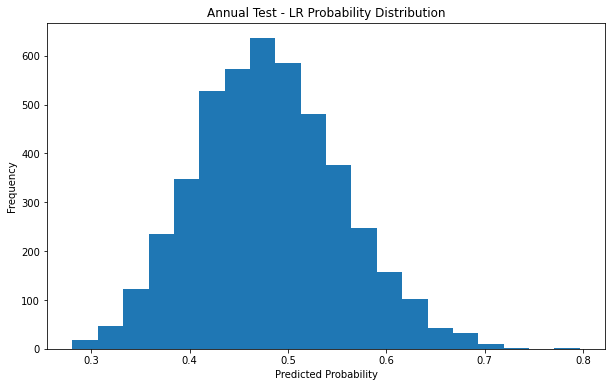

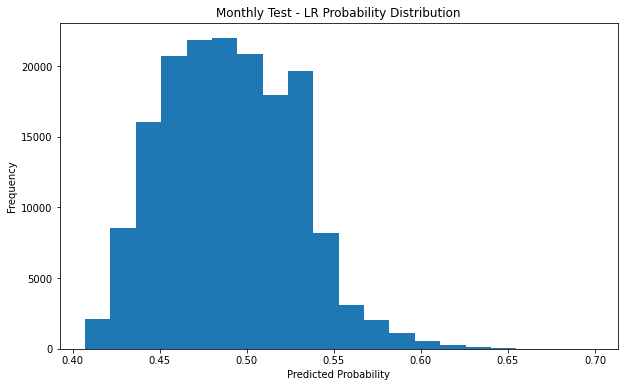

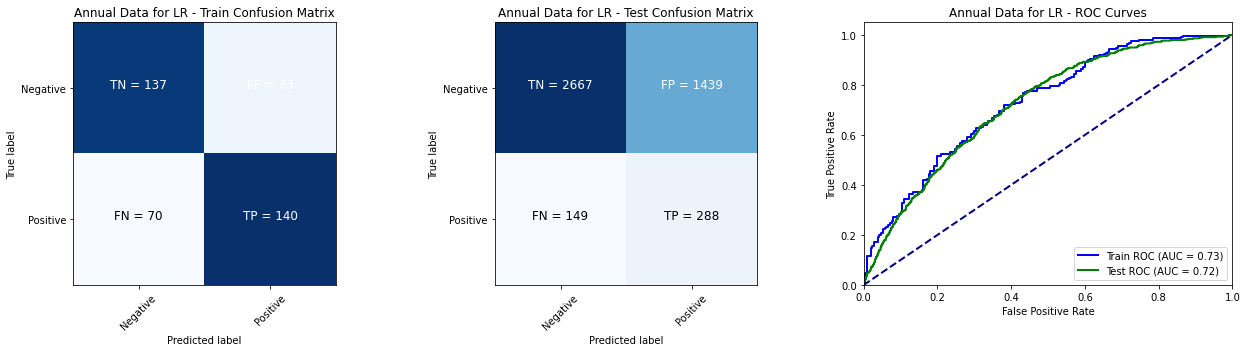

Annual Data for LR Metrics:
Train - Precision: 0.6573, Recall: 0.6667, AUC: 0.7275
Test  - Precision: 0.1668, Recall: 0.6590, AUC: 0.7198


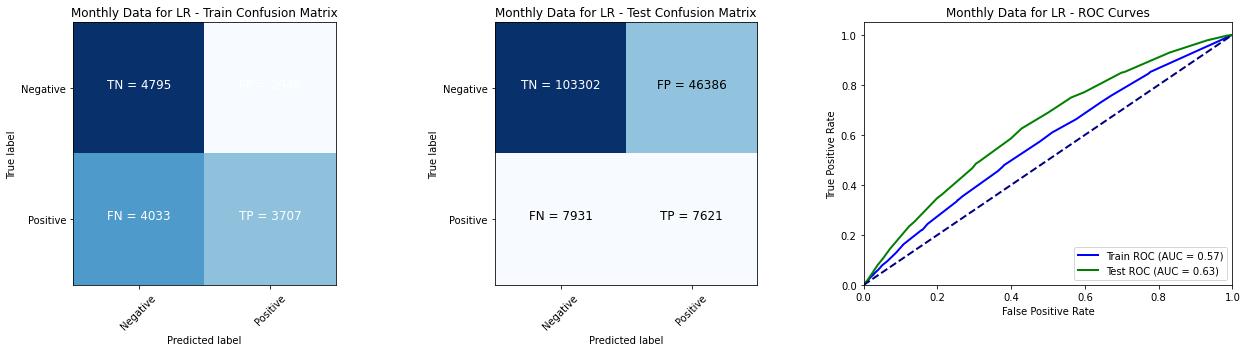

Monthly Data for LR Metrics:
Train - Precision: 0.5573, Recall: 0.4789, AUC: 0.5680
Test  - Precision: 0.1411, Recall: 0.4900, AUC: 0.6306


In [0]:
# Making predictions.
annual_train_pred_lr, annual_test_pred_lr = get_predictions(model_annual_lr, train_annual, test_annual)
monthly_train_pred_lr, monthly_test_pred_lr = get_predictions(model_monthly_lr, train_monthly, test_monthly)
# Getting feature names for each model
annual_feature_names = annual_feature_cols  # From pre-processing step
monthly_feature_names = monthly_feature_cols  # From pre-processing step
# 5. Plot with correct feature names for each model
plot_coefficients(model_annual_lr, annual_feature_names, "Annual Model Coefficients LR")
plot_coefficients(model_monthly_lr, monthly_feature_names, "Monthly Model Coefficients LR")
# 6. Plot probability distribution
plot_probability_distribution(annual_test_pred_lr, "Annual Test - LR Probability Distribution")
plot_probability_distribution(monthly_test_pred_lr, "Monthly Test - LR Probability Distribution")
# 7. Evaluate models with combined plots
evaluate_model(annual_train_pred_lr, annual_test_pred_lr, "Annual Data for LR")
evaluate_model(monthly_train_pred_lr, monthly_test_pred_lr, "Monthly Data for LR")

#### Decision Tree Models.

In [0]:
# 4. Decision Tree Models using found optimal parameters.
dt_annual = DecisionTreeClassifier(featuresCol='features',  
                                 labelCol='response',
                                 maxDepth=3,
                                 seed=1147)
dt_monthly = DecisionTreeClassifier(featuresCol='features',
                                  labelCol='response',
                                  maxDepth=5,
                                  seed=1147)
# Creating the pipelines.
pipeline_annual_dt = Pipeline(stages=[annual_assembler, dt_annual])
pipeline_monthly_dt = Pipeline(stages=[monthly_assembler, dt_monthly])
# Fitting the models.
model_annual_dt = pipeline_annual_dt.fit(train_annual)
model_monthly_dt = pipeline_monthly_dt.fit(train_monthly)

#### Comment on hyper-parameter tuning:
- The optimal parameters were found using a 3-fold crossvalidation method in an external file due to extremely long search times. Below is a snippet of the search code carried out on annual and monthly data for the decision tree classifiers.

In [0]:
"""
# 1. Define evaluator
dt_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")

# 2. ANNUAL MODEL 
annual_dt_cv = CrossValidator(estimator=DecisionTreeClassifier(featuresCol='features', labelCol='response'), estimatorParamMaps=ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [2, 3, 4]).addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10]).build(), evaluator=dt_evaluator, numFolds=3, seed=1147)

# 3. MONTHLY MODEL  
monthly_dt_cv = CrossValidator(estimator=DecisionTreeClassifier(featuresCol='features', labelCol='response'), estimatorParamMaps=ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [3, 5, 7]).addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10]).build(), evaluator=dt_evaluator, numFolds=3, seed=1147)

# 4. Pipelines
annual_dt_pipeline = Pipeline(stages=[annual_assembler, annual_dt_cv])
monthly_dt_pipeline = Pipeline(stages=[monthly_assembler, monthly_dt_cv])

# 5. Train models + results
model_annual_dt = annual_dt_pipeline.fit(train_annual)
model_monthly_dt = monthly_dt_pipeline.fit(train_monthly)
print(f"Annual Best: max_depth={model_annual_dt.stages[-1].bestModel.getMaxDepth()}, min_instances={model_annual_dt.stages[-1].bestModel.getMinInstancesPerNode()}")
print(f"Monthly Best: max_depth={model_monthly_dt.stages[-1].bestModel.getMaxDepth()}, min_instances={model_monthly_dt.stages[-1].bestModel.getMinInstancesPerNode()}")

# Predictions (uncomment when ready)
# annual_preds = model_annual_dt.transform(test_annual)
# monthly_preds = model_monthly_dt.transform(test_monthly)
"""

Out[20]: '\n# 1. Define evaluator\ndt_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")\n\n# 2. ANNUAL MODEL \nannual_dt_cv = CrossValidator(estimator=DecisionTreeClassifier(featuresCol=\'features\', labelCol=\'response\'), estimatorParamMaps=ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [2, 3, 4]).addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10]).build(), evaluator=dt_evaluator, numFolds=3, seed=1147)\n\n# 3. MONTHLY MODEL  \nmonthly_dt_cv = CrossValidator(estimator=DecisionTreeClassifier(featuresCol=\'features\', labelCol=\'response\'), estimatorParamMaps=ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [3, 5, 7]).addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10]).build(), evaluator=dt_evaluator, numFolds=3, seed=1147)\n\n# 4. Pipelines\nannual_dt_pipeline = Pipeline(stages=[annual_assembler, annual_dt_cv])\nmonthly_dt_pipeline = Pipeline(stages=[monthly_assembler, monthly_dt_cv])\n\n# 5. Trai

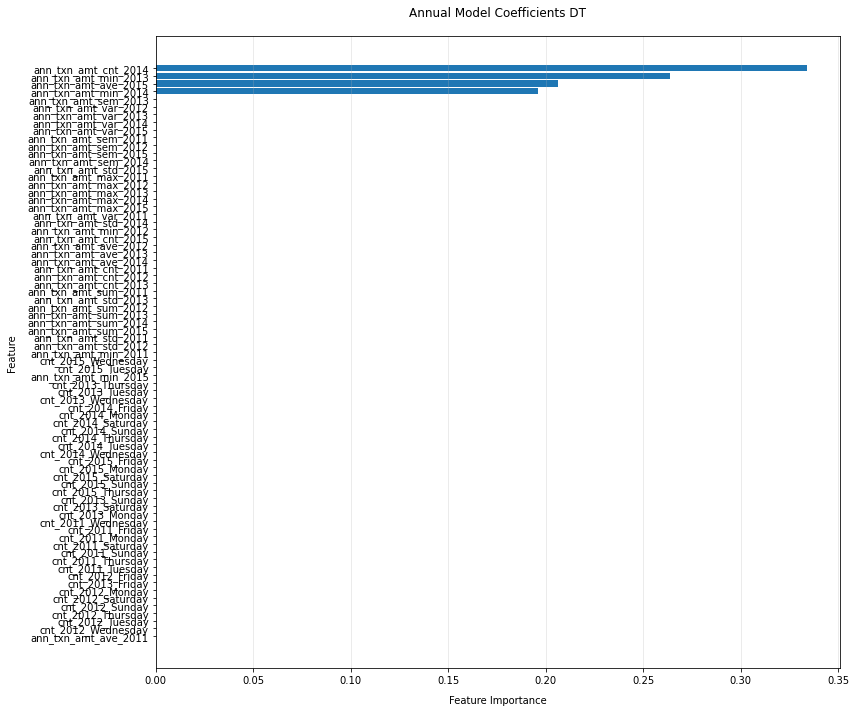

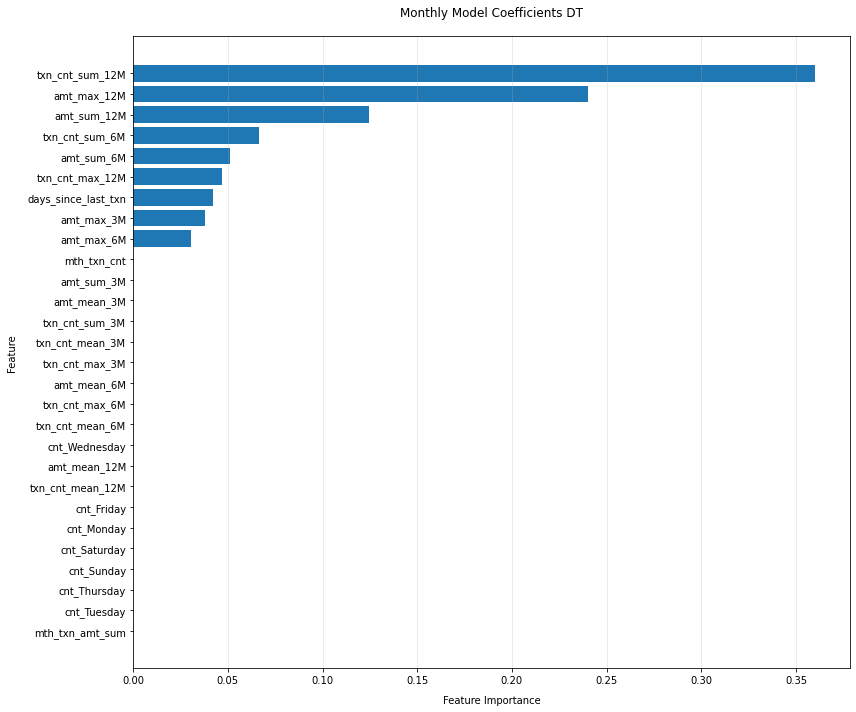

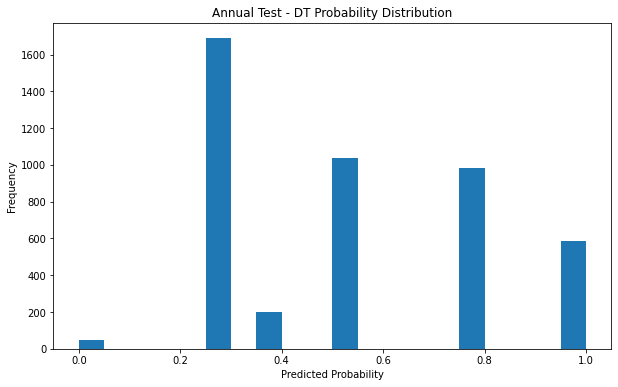

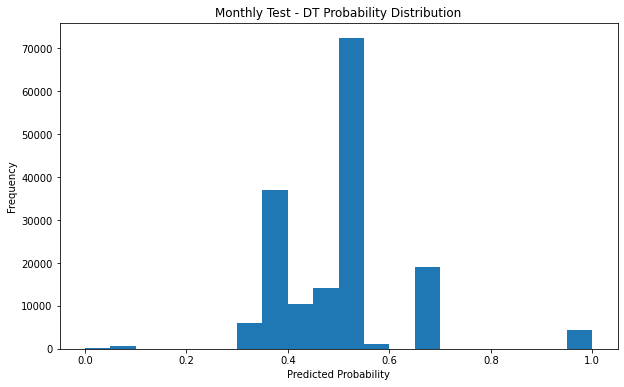

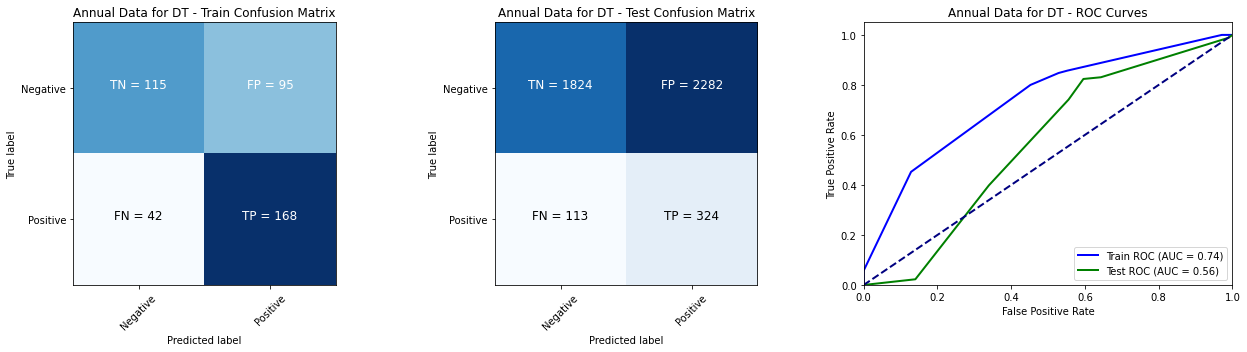

Annual Data for DT Metrics:
Train - Precision: 0.6388, Recall: 0.8000, AUC: 0.7363
Test  - Precision: 0.1243, Recall: 0.7414, AUC: 0.5627


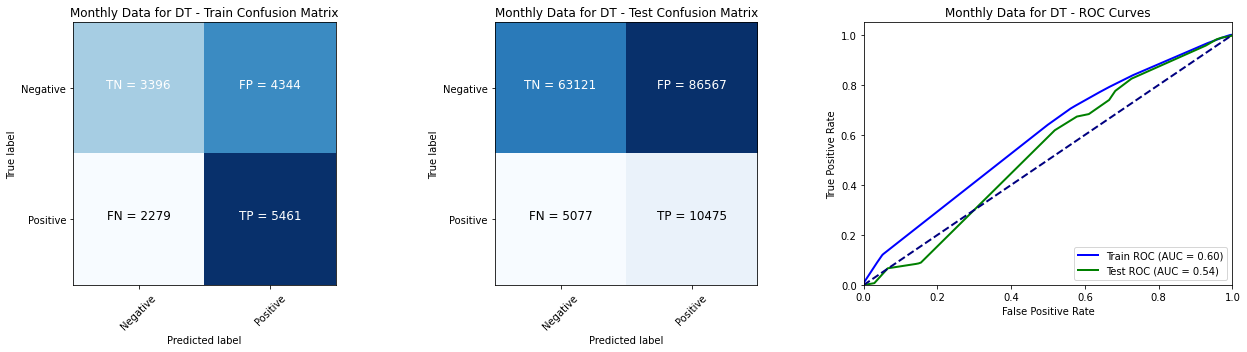

Monthly Data for DT Metrics:
Train - Precision: 0.5570, Recall: 0.7056, AUC: 0.5957
Test  - Precision: 0.1079, Recall: 0.6735, AUC: 0.5351


In [0]:
# Making predictions.
annual_train_pred_dt, annual_test_pred_dt = get_predictions(model_annual_dt, train_annual, test_annual)
monthly_train_pred_dt, monthly_test_pred_dt = get_predictions(model_monthly_dt, train_monthly, test_monthly)
# Getting feature names for each model
annual_feature_names = annual_feature_cols  # From pre-processing step
monthly_feature_names = monthly_feature_cols  # From pre-processing step
# 5. Plot with correct feature names for each model
plot_feature_importance(model_annual_dt, annual_feature_names, "Annual Model Coefficients DT")
plot_feature_importance(model_monthly_dt, monthly_feature_names, "Monthly Model Coefficients DT")
# 6. Plot probability distribution
plot_probability_distribution(annual_test_pred_dt, "Annual Test - DT Probability Distribution")
plot_probability_distribution(monthly_test_pred_dt, "Monthly Test - DT Probability Distribution")
# 7. Evaluate models with combined plots
evaluate_model(annual_train_pred_dt, annual_test_pred_dt, "Annual Data for DT")
evaluate_model(monthly_train_pred_dt, monthly_test_pred_dt, "Monthly Data for DT")

#### Annual Data Random Forest Models.

In [0]:
# 4. Random Forest Models using found optimal parameters.
rf_annual = RandomForestClassifier(featuresCol='features',
                                 labelCol='response',
                                 maxDepth=3,
                                 seed=1147)
rf_monthly = RandomForestClassifier(featuresCol='features',
                                  labelCol='response',
                                  maxDepth=5,
                                  seed=1147)
# Creating the Pipelines.
pipeline_annual_rf = Pipeline(stages=[annual_assembler, rf_annual])
pipeline_monthly_rf = Pipeline(stages=[monthly_assembler, rf_monthly])
# Fitting the models.
model_annual_rf = pipeline_annual_rf.fit(train_annual)
model_monthly_rf = pipeline_monthly_rf.fit(train_monthly)

#### Comment on hyper-parameter tuning:
- The optimal parameters were found using a 3-fold crossvalidation method in an external file due to extremely long search times. Below is a snippet of the search code carried out on annual and monthly data for the Random Forest Classifier.

In [0]:
"""
# RANDOM FOREST WITH CV FOR max_depth ONLY

# 1. Define evaluator
rf_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")

# 2. ANNUAL MODEL (CV for max_depth)
annual_rf_cv = CrossValidator(
    estimator=RandomForestClassifier(featuresCol='features', labelCol='response'),  # Fixed params
    estimatorParamMaps=ParamGridBuilder().addGrid(RandomForestClassifier.maxDepth, [2, 3, 4]).build(),  # Only CV max_depth
    evaluator=rf_evaluator, numFolds=3, seed=1147)

# 3. MONTHLY MODEL (CV for max_depth)  
monthly_rf_cv = CrossValidator(
    estimator=RandomForestClassifier(featuresCol='features', labelCol='response'),  # Fixed params
    estimatorParamMaps=ParamGridBuilder().addGrid(RandomForestClassifier.maxDepth, [3, 5, 7]).build(),  # Only CV max_depth
    evaluator=rf_evaluator, numFolds=3, seed=1147)

# 4. Pipelines
annual_rf_pipeline = Pipeline(stages=[annual_assembler, annual_rf_cv])
monthly_rf_pipeline = Pipeline(stages=[monthly_assembler, monthly_rf_cv])

# 5. Train models + results
model_annual_rf = annual_rf_pipeline.fit(train_annual)
model_monthly_rf = monthly_rf_pipeline.fit(train_monthly)
print(f"Annual Best max_depth: {model_annual_rf.stages[-1].bestModel.getMaxDepth()}")
print(f"Monthly Best max_depth: {model_monthly_rf.stages[-1].bestModel.getMaxDepth()}")

# Predictions (uncomment when ready)
# annual_preds = model_annual_rf.transform(test_annual)
# monthly_preds = model_monthly_rf.transform(test_monthly)
"""

Out[23]: '\n# RANDOM FOREST WITH CV FOR max_depth ONLY\n\n# 1. Define evaluator\nrf_evaluator = BinaryClassificationEvaluator(labelCol="response", metricName="areaUnderROC")\n\n# 2. ANNUAL MODEL (CV for max_depth)\nannual_rf_cv = CrossValidator(\n    estimator=RandomForestClassifier(featuresCol=\'features\', labelCol=\'response\'),  # Fixed params\n    estimatorParamMaps=ParamGridBuilder().addGrid(RandomForestClassifier.maxDepth, [2, 3, 4]).build(),  # Only CV max_depth\n    evaluator=rf_evaluator, numFolds=3, seed=1147)\n\n# 3. MONTHLY MODEL (CV for max_depth)  \nmonthly_rf_cv = CrossValidator(\n    estimator=RandomForestClassifier(featuresCol=\'features\', labelCol=\'response\'),  # Fixed params\n    estimatorParamMaps=ParamGridBuilder().addGrid(RandomForestClassifier.maxDepth, [3, 5, 7]).build(),  # Only CV max_depth\n    evaluator=rf_evaluator, numFolds=3, seed=1147)\n\n# 4. Pipelines\nannual_rf_pipeline = Pipeline(stages=[annual_assembler, annual_rf_cv])\nmonthly_rf_pipeline = Pip

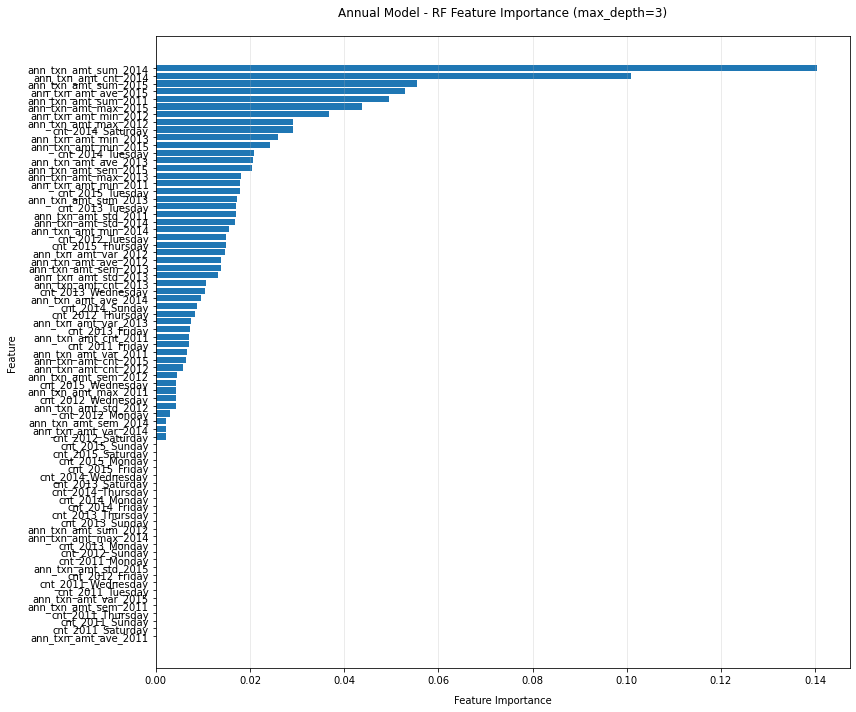

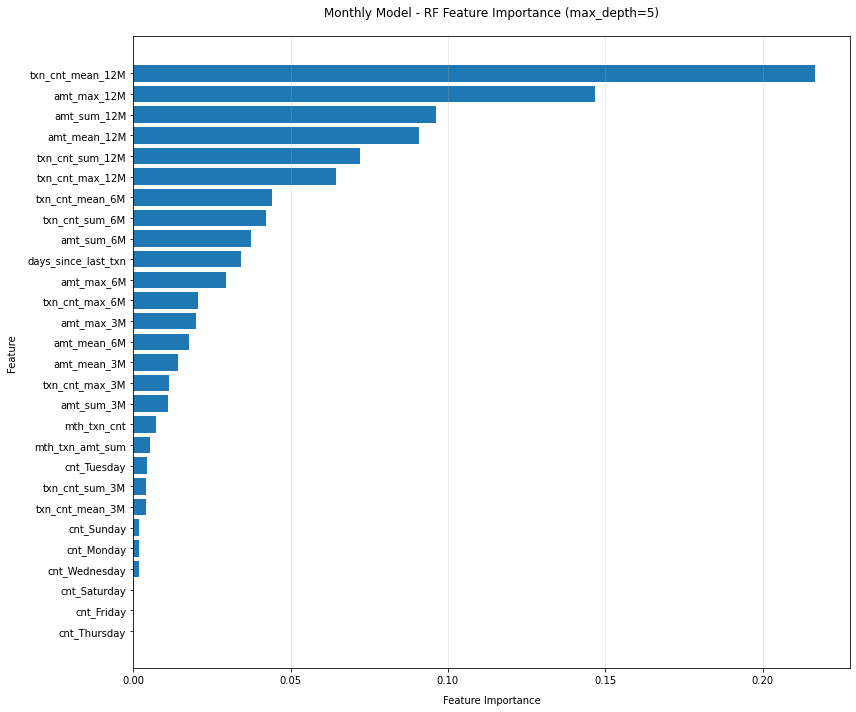

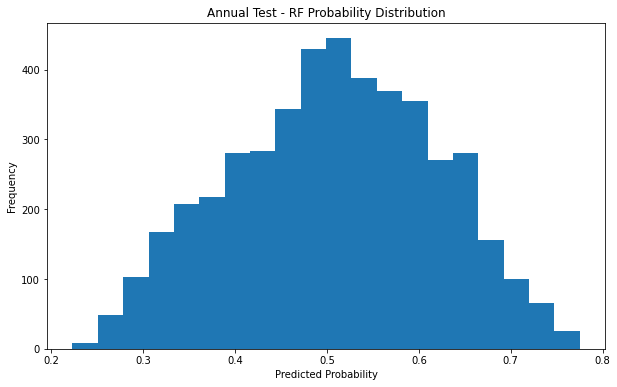

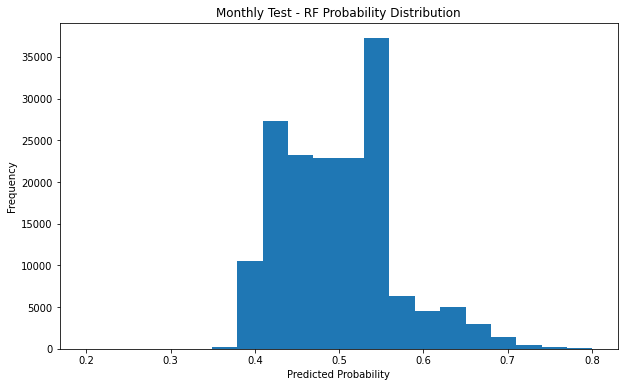

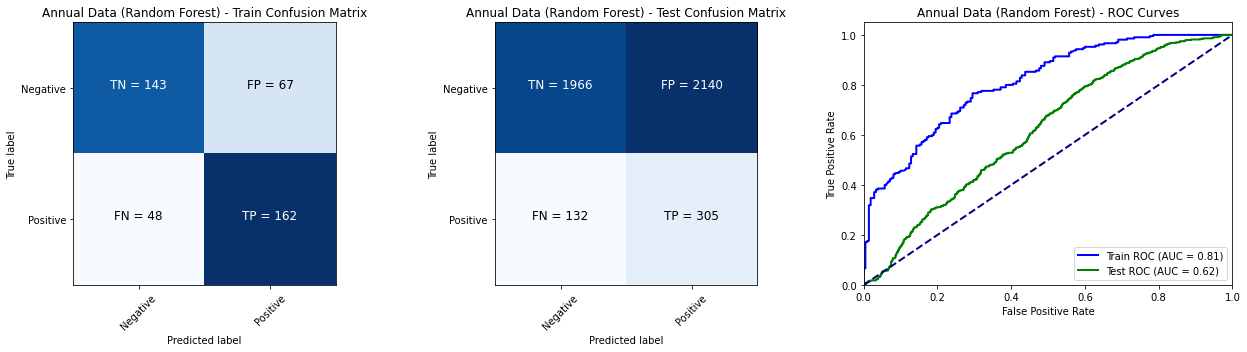

Annual Data (Random Forest) Metrics:
Train - Precision: 0.7074, Recall: 0.7714, AUC: 0.8094
Test  - Precision: 0.1247, Recall: 0.6979, AUC: 0.6180


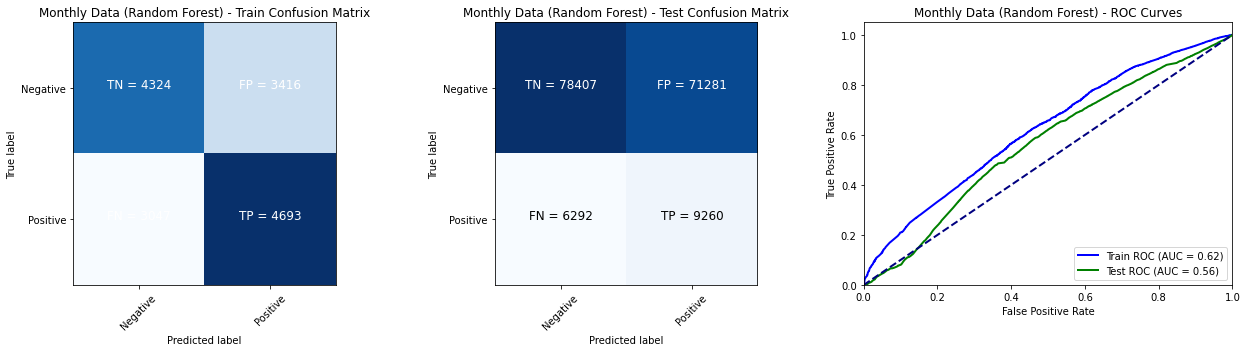

Monthly Data (Random Forest) Metrics:
Train - Precision: 0.5787, Recall: 0.6063, AUC: 0.6204
Test  - Precision: 0.1150, Recall: 0.5954, AUC: 0.5636


In [0]:
# Making predictions
annual_train_pred_rf, annual_test_pred_rf = get_predictions(model_annual_rf, train_annual, test_annual)
monthly_train_pred_rf, monthly_test_pred_rf = get_predictions(model_monthly_rf, train_monthly, test_monthly)
# Getting feature names
annual_feature_names = annual_feature_cols
monthly_feature_names = monthly_feature_cols
# 5. Plot feature importance
plot_feature_importance(model_annual_rf, annual_feature_names, "Annual Model - RF Feature Importance (max_depth=3)")
plot_feature_importance(model_monthly_rf, monthly_feature_names, "Monthly Model - RF Feature Importance (max_depth=5)")
# 6. Plot probability distribution
plot_probability_distribution(annual_test_pred_rf, "Annual Test - RF Probability Distribution")
plot_probability_distribution(monthly_test_pred_rf, "Monthly Test - RF Probability Distribution")
# 7. Evaluate models
evaluate_model(annual_train_pred_rf, annual_test_pred_rf, "Annual Data (Random Forest)")
evaluate_model(monthly_train_pred_rf, monthly_test_pred_rf, "Monthly Data (Random Forest)")

### Q 1.3. Comparison of Methods

#### Feature Engineering and Modeling Approaches

| Feature Engineering | Model Type         | Regularization/Max Depth | Feature Count | Top Feature              | Second Feature        | Prob Distribution Shape        | Test AUC | Test Precision | Test Recall | Train AUC | Train Precision | Train Recall |
|---------------------|--------------------|--------------------------|---------------|--------------------------|-----------------------|--------------------------------|----------|----------------|-------------|-----------|----------------|-------------|
| **Annual**          | Logistic Regression| λ=0.07 (L1)             | 5            | ann_txn_amt_cnt_2014     | ann_txn_amt_mean_2015  | Slightly right-skewed normal   | 0.7198   | 0.1668         | 0.6590      | 0.7275    | 0.6573         | 0.6667      |
| **Annual**          | Decision Tree      | max_depth=3              | 4             | ann_txn_amt_cnt_2014     | ann_txn_amt_min_2013  | right-skewed         | 0.5627   | 0.1243         | 0.7414      | 0.7363    | 0.6388         | 0.8000      |
| **Annual**          | Random Forest      | max_depth=3              | 49            | ann_txn_amt_sum_2014     | ann_txn_amt_cnt_2014  | Left-skewed normal           | 0.6180   | 0.1247         | 0.6979      | 0.8094    | 0.7074         | 0.7714      |
| **Monthly**         | Logistic Regression| λ=0.02 (L1)             | 3            | txn_cnt_sum_12M              | txn_cnt_mean_12M          | Slightly right-skewed normal   | 0.6306   | 0.1411         | 0.4900      | 0.5680    | 0.5573         | 0.4789      |
| **Monthly**         | Decision Tree      | max_depth=5              | 9            |  txn_cnt_sum_12M             | amt_max_12M           | Left-skewed normal             | 0.5351   | 0.1079         | 0.6735      | 0.5957    | 0.5570         | 0.7056      |
| **Monthly**         | Random Forest      | max_depth=5             | 25            | txn_cnt_mean_12M              | amt_max_12M          | Slightly left-skewed bimodal   | 0.5636   | 0.1150         | 0.5954      | 0.6204    | 0.5787         | 0.6063      |

### Observations and Overall Selection

#### Annual Data
- **Logistic Regression (L1)** shows balanced performance with moderate feature selection (5 features) and the highest Testing AUC (0.7198) among annual models.
- **Decision Tree** demonstrates the highest Testing Recall (0.7414) but suffers from lower AUC (0.5627) and extreme right-skewed probability distribution, suggesting potential over-simplification.
- **Random Forest** shows signs of overfitting with a large gap between Train AUC (0.8094) and Test AUC (0.6180), despite using 49 features.

**Best Choice for Annual Data**: **Logistic Regression (L1)**, due to:
- Best balance between AUC and Recall
- Clean probability distribution
- Moderate feature selection (5 features)
- λ=0.07 provides good regularization

#### Monthly Data
- **Logistic Regression (L1)** again shows the best AUC (0.6306) with only 3 features, but lower Recall (0.4900).
- **Decision Tree** achieves highest Testing Recall (0.6735) but poorest AUC (0.5351) and Precision (0.1079).
- **Random Forest** shows modest improvement over Decision Tree in AUC (0.5636) while maintaining similar Recall (0.5954).

**Best Choice for Monthly Data**: **Logistic Regression (L1)**, due to:
- Highest overall discriminative power (AUC)
- Most stable probability distribution
- Minimal feature requirements (3 features)
- λ=0.02 provides appropriate regularization

#### Overall Selection
- **Logistic Regression with Annual Data** remains the superior choice for deployment, offering:
  - Best combination of AUC (0.7198) and Recall (0.6590)
  - Clean, interpretable probability outputs
  - Efficient feature selection
  - Proven generalization (smallest train-test gap)

---

### Summary Comparison

| Criteria                | Annual: Logistic (L1) | Monthly: Logistic (L1) | Overall Selection         |
|-------------------------|-----------------------|------------------------|---------------------------|
| **Test AUC**            | 0.7198               | 0.6306                 | **Annual Logistic**       |
| **Test Precision**      | 0.1668               | 0.1411                 |                           |
| **Test Recall**         | 0.6590               | 0.4900                 |                           |
| **Feature Count**       | 5                    | 3                      |                           |
| **Regularization**      | λ=0.07 (L1)          | λ=0.02 (L1)            |                           |
| **Prob Distribution**  | Right-skewed normal  | Right-skewed normal    |                           |